# Microsoft Malware detection

In [151]:
import os
import shutil
import random
import pickle
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss

<h1>1.Business/Real-world Problem</h1>

<h2>1.1. What is Malware? </h2>

<p>
The term malware is a contraction of malicious software. Put simply, malware is any piece of software that was written with the intent of doing harm to data, devices or to people. <br> 
Source: https://www.avg.com/en/signal/what-is-malware
<p>

<h2> 1.2. Problem Statement </h2>

<p>
    In the past few years, the malware industry has grown very rapidly that, the syndicates invest heavily in technologies to evade traditional protection, forcing the anti-malware groups/communities to build more robust softwares to detect and terminate these attacks. The major part of protecting a computer system from a malware attack is to <b>identify whether a given piece of file/software<b> is a malware. 
</p>


<h2>1.3 Source/Useful Links </h2>

<p>    Microsoft has been very active in building anti-malware products over the years  and it runs it’s anti-malware utilities over <b>150 million computers</b> around the world. This generates tens of millions of daily data points to be analyzed as potential malware. In order to be effective in analyzing and classifying such large amounts of data, we need to be able to group them into groups and identify their respective families. 
<br>
<br>
This dataset provided by Microsoft contains about 9 classes of malware.
,</p>
<p>
<b> Source: </b> https://www.kaggle.com/c/malware-classification
</p>

<h2>1.4. Real-world/Business objectives and constraints.</h2>


1. Minimize multi-class error.
2. Multi-class probability estimates.
3. Malware detection should not take hours and block the user's computer. It should fininsh in a few seconds or a minute.

<h1>2. Machine Learning Problem</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

<li> Source : https://www.kaggle.com/c/malware-classification/data </li>
<li> For every malware, we have two files <ol> <li> .asm file (read more: https://www.reviversoft.com/file-extensions/asm) </li><li>.bytes file (the raw data contains the hexadecimal representation of the file's binary content, without the PE header)</li></ol></li> 
    
<li>Total train dataset consist of 200GB data out of which 50Gb of data is .bytes files and 150GB of data is .asm files:  </li>
<li><b>Lots of Data for a single-box/computer.</b> </li>

<li>There are total 10,868 .bytes files and 10,868 asm files total 21,736 files </li>

<li>There are 9 types of malwares (9 classes) in our give data</li>
<li> Types of Malware:
    <ol>
        <li> Ramnit </li>
        <li> Lollipop </li>
        <li> Kelihos_ver3 </li>
        <li> Vundo </li>
        <li> Simda </li>
        <li> Tracur </li>
        <li> Kelihos_ver1 </li>
        <li> Obfuscator.ACY </li>
        <li> Gatak </li>
    </ol>
</li>

<h3>2.1.2. Example Data Point</h3>

<p style = "font-size:18px"><b> .asm file</b></p>
<pre>
.text:00401000								       assume es:nothing, ss:nothing, ds:_data,	fs:nothing, gs:nothing
.text:00401000 56							       push    esi
.text:00401001 8D 44 24	08						       lea     eax, [esp+8]
.text:00401005 50							       push    eax
.text:00401006 8B F1							       mov     esi, ecx
.text:00401008 E8 1C 1B	00 00						       call    ??0exception@std@@QAE@ABQBD@Z ; std::exception::exception(char const * const &)
.text:0040100D C7 06 08	BB 42 00					       mov     dword ptr [esi],	offset off_42BB08
.text:00401013 8B C6							       mov     eax, esi
.text:00401015 5E							       pop     esi
.text:00401016 C2 04 00							       retn    4
.text:00401016						       ; ---------------------------------------------------------------------------
.text:00401019 CC CC CC	CC CC CC CC					       align 10h
.text:00401020 C7 01 08	BB 42 00					       mov     dword ptr [ecx],	offset off_42BB08
.text:00401026 E9 26 1C	00 00						       jmp     sub_402C51
.text:00401026						       ; ---------------------------------------------------------------------------
.text:0040102B CC CC CC	CC CC						       align 10h
.text:00401030 56							       push    esi
.text:00401031 8B F1							       mov     esi, ecx
.text:00401033 C7 06 08	BB 42 00					       mov     dword ptr [esi],	offset off_42BB08
.text:00401039 E8 13 1C	00 00						       call    sub_402C51
.text:0040103E F6 44 24	08 01						       test    byte ptr	[esp+8], 1
.text:00401043 74 09							       jz      short loc_40104E
.text:00401045 56							       push    esi
.text:00401046 E8 6C 1E	00 00						       call    ??3@YAXPAX@Z    ; operator delete(void *)
.text:0040104B 83 C4 04							       add     esp, 4
.text:0040104E
.text:0040104E						       loc_40104E:			       ; CODE XREF: .text:00401043j
.text:0040104E 8B C6							       mov     eax, esi
.text:00401050 5E							       pop     esi
.text:00401051 C2 04 00							       retn    4
.text:00401051						       ; ---------------------------------------------------------------------------
</pre>
<p style = "font-size:18px"><b> .bytes file</b></p>
<pre>
00401000 00 00 80 40 40 28 00 1C 02 42 00 C4 00 20 04 20
00401010 00 00 20 09 2A 02 00 00 00 00 8E 10 41 0A 21 01
00401020 40 00 02 01 00 90 21 00 32 40 00 1C 01 40 C8 18
00401030 40 82 02 63 20 00 00 09 10 01 02 21 00 82 00 04
00401040 82 20 08 83 00 08 00 00 00 00 02 00 60 80 10 80
00401050 18 00 00 20 A9 00 00 00 00 04 04 78 01 02 70 90
00401060 00 02 00 08 20 12 00 00 00 40 10 00 80 00 40 19
00401070 00 00 00 00 11 20 80 04 80 10 00 20 00 00 25 00
00401080 00 00 01 00 00 04 00 10 02 C1 80 80 00 20 20 00
00401090 08 A0 01 01 44 28 00 00 08 10 20 00 02 08 00 00
004010A0 00 40 00 00 00 34 40 40 00 04 00 08 80 08 00 08
004010B0 10 00 40 00 68 02 40 04 E1 00 28 14 00 08 20 0A
004010C0 06 01 02 00 40 00 00 00 00 00 00 20 00 02 00 04
004010D0 80 18 90 00 00 10 A0 00 45 09 00 10 04 40 44 82
004010E0 90 00 26 10 00 00 04 00 82 00 00 00 20 40 00 00
004010F0 B4 00 00 40 00 02 20 25 08 00 00 00 00 00 00 00
00401100 08 00 00 50 00 08 40 50 00 02 06 22 08 85 30 00
00401110 00 80 00 80 60 00 09 00 04 20 00 00 00 00 00 00
00401120 00 82 40 02 00 11 46 01 4A 01 8C 01 E6 00 86 10
00401130 4C 01 22 00 64 00 AE 01 EA 01 2A 11 E8 10 26 11
00401140 4E 11 8E 11 C2 00 6C 00 0C 11 60 01 CA 00 62 10
00401150 6C 01 A0 11 CE 10 2C 11 4E 10 8C 00 CE 01 AE 01
00401160 6C 10 6C 11 A2 01 AE 00 46 11 EE 10 22 00 A8 00
00401170 EC 01 08 11 A2 01 AE 10 6C 00 6E 00 AC 11 8C 00
00401180 EC 01 2A 10 2A 01 AE 00 40 00 C8 10 48 01 4E 11
00401190 0E 00 EC 11 24 10 4A 10 04 01 C8 11 E6 01 C2 00

</pre>

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes of malware that we need to classify a given a data point => Multi class classification problem    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/malware-classification#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* Some Latency constraints.

<h2>2.3. Train and Test Dataset </h2>

Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h2>2.4. Useful blogs, videos and reference papers</h2>

<p>
http://blog.kaggle.com/2015/05/26/microsoft-malware-winners-interview-1st-place-no-to-overfitting/ <br>
https://arxiv.org/pdf/1511.04317.pdf <br>
First place solution in Kaggle competition: https://www.youtube.com/watch?v=VLQTRlLGz5Y <br>
https://github.com/dchad/malware-detection <br>
http://vizsec.org/files/2011/Nataraj.pdf <br>
https://www.dropbox.com/sh/gfqzv0ckgs4l1bf/AAB6EelnEjvvuQg2nu_pIB6ua?dl=0 <br>
" Cross validation is more trustworthy than domain knowledge." 
</p>

- ### Separating byte files and asm files

In [6]:
src = 'data/train'
bdest = 'data/train/byte'
adest = 'data/train/asm'
file_lst = os.listdir('data/train')
print(len(file_lst))
byte_lst = [x for x in file_lst if '.byte' in x]
print(len(byte_lst))
asm_lst = [x for x in file_lst if '.asm' in x]
print(len(asm_lst))

3
0
0


In [34]:
for x in byte_lst:
    shutil.move(os.path.join(src,x),bdest)

In [35]:
for x in asm_lst:
    shutil.move(os.path.join(src,x),adest)

In [37]:
print(len(os.listdir('data/train/byte')))
print(len(os.listdir('data/train/asm')))

10868
10868


<h2>3.1. Distribution of malware classes in whole data set </h2>

In [2]:
lables = pd.read_csv('data/trainLabels.csv')

In [43]:
lables.Class.value_counts()

3    2942
2    2478
1    1541
8    1228
9    1013
6     751
4     475
7     398
5      42
Name: Class, dtype: int64

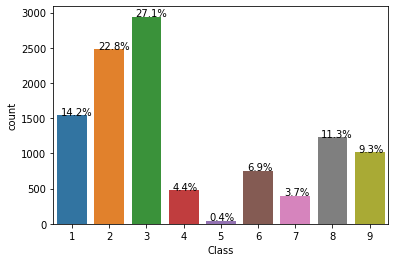

In [47]:
sns.countplot(x=lables['Class'])
ax= plt.gca()
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/len(lables.Class)), (p.get_x()+0.1, p.get_height()+5))

<h2>3.2. Feature extraction </h2>

<h3> 3.2.1 File size  of byte files as a feature </h3>

In [8]:
byte_lst = os.listdir('data/train/byte')
asm_lst = os.listdir('data/train/asm')

10868

In [7]:
def get_size(strn):
    filen = strn+'.txt' # first ir was +'.byte' but i didn't save the data and later we convert all byte files to txt so now we are using txt sizes, if you ever again run the cell with bytefiles do not worry uf we get different sizes
    return (os.stat(os.path.join(bdest,filen)).st_size/(1024.0*1024.0))

In [8]:
lables['fsize'] = lables.Id.apply(get_size)

In [19]:
lables.head()

Id  Class     fsize
0  01kcPWA9K2BOxQeS5Rju      1  0.574219
1  04EjIdbPV5e1XroFOpiN      1  0.717773
2  05EeG39MTRrI6VY21DPd      1  0.430664
3  05rJTUWYAKNegBk2wE8X      1  2.356689
4  0AnoOZDNbPXIr2MRBSCJ      1  0.478516

<AxesSubplot:xlabel='Class', ylabel='fsize'>

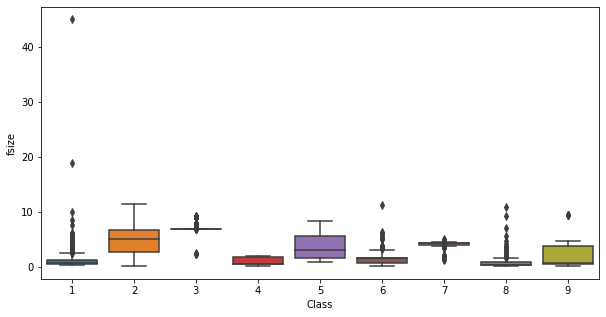

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="Class", y="fsize", data=lables,ax=ax)

<AxesSubplot:xlabel='Class', ylabel='fsize'>

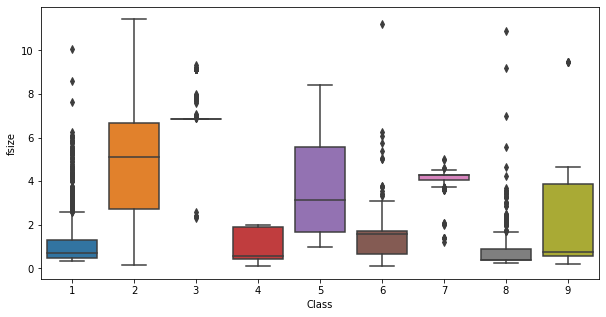

In [21]:
tempd = lables[lables['fsize']<12]
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="Class", y="fsize", data=tempd,ax=ax)

<h3>3.2.3 feature extraction from byte files </h3>

In [4]:
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000

files = os.listdir(bdest)
filenames=[]
array=[]
for file in tqdm(files):
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('data/train/byte/'+file+".txt", 'w+')
        with open('data/train/byte/'+file+'.bytes',"r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('data/train/byte/'+file+'.bytes')
        text_file.close()

files = os.listdir(bdest)
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0


#program to convert into bag of words of bytefiles
#this is custom-built bag of words this is unigram bag of words
byte_feature_file=open('data/train/result.csv','w+')
byte_feature_file.write("Id,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??,")
byte_feature_file.write("\n")
for file in tqdm(files):
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('data/train/byte/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i in feature_matrix[k]:
        byte_feature_file.write(str(i)+",")
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

100%|██████████| 10868/10868 [3:24:18<00:00,  1.13s/it]


In [9]:
byte_features=pd.read_csv("data/train/result.csv")
byte_features.head()

Id       0     1     2     3     4     5     6     7  \
0  01azqd4InC7m9JpocGv5.txt  601905  3905  2816  3832  3345  3242  3650  3201   
1  01IsoiSMh5gxyDYTl4CB.txt   39755  8337  7249  7186  8663  6844  8420  7589   
2  01jsnpXSAlgw6aPeDxrU.txt   93506  9542  2568  2438  8925  9330  9007  2342   
3  01kcPWA9K2BOxQeS5Rju.txt   21091  1213   726   817  1257   625   550   523   
4  01SuzwMJEIXsK7A8dQbl.txt   19764   710   302   433   559   410   262   249   

      8  ...    f8    f9    fa    fb    fc    fd     fe     ff     ??  \
0  2965  ...  3687  3101  3211  3097  2758  3099   2759   5753   1824   
1  9291  ...  6536   439   281   302  7639   518  17001  54902   8588   
2  9107  ...  2358  2242  2885  2863  2471  2786   2680  49144    468   
3  1078  ...   873   485   462   516  1133   471    761   7998  13940   
4   422  ...   947   350   209   239   653   221    242   2199   9008   

   Unnamed: 258  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

[5 rows x 259 columns]

In [10]:
byte_features = byte_features.iloc[:,:-1]

In [11]:
byte_features['Id'] = byte_features['Id'].apply(lambda x: x.split('.')[0])

Normalization

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
byt_scl = pd.DataFrame(min_max_scaler.fit_transform(byte_features.iloc[:,1:]))
byt_scl['Id'] = byte_features['Id']
byt_scl

0         1         2         3         4         5         6  \
0      0.262806  0.005498  0.001567  0.002067  0.002048  0.001835  0.002058   
1      0.017358  0.011737  0.004033  0.003876  0.005303  0.003873  0.004747   
2      0.040827  0.013434  0.001429  0.001315  0.005464  0.005280  0.005078   
3      0.009209  0.001708  0.000404  0.000441  0.000770  0.000354  0.000310   
4      0.008629  0.001000  0.000168  0.000234  0.000342  0.000232  0.000148   
...         ...       ...       ...       ...       ...       ...       ...   
10863  0.002300  0.001657  0.000596  0.000659  0.000758  0.000656  0.000644   
10864  0.001324  0.000420  0.000138  0.000158  0.000168  0.000121  0.000114   
10865  0.002476  0.000311  0.000150  0.000174  0.000192  0.000088  0.000140   
10866  0.001588  0.000615  0.000252  0.000273  0.000313  0.000221  0.000243   
10867  0.001543  0.000525  0.000214  0.000233  0.000303  0.000226  0.000222   

              7         8         9  ...       248       249       250  \
0      0.002946  0.002638  0.003531  ...  0.019969  0.013560  0.013107   
1      0.006984  0.008267  0.000394  ...  0.035399  0.001920  0.001147   
2      0.002155  0.008104  0.002707  ...  0.012771  0.009804  0.011777   
3      0.000481  0.000959  0.000521  ...  0.004728  0.002121  0.001886   
4      0.000229  0.000376  0.000246  ...  0.005129  0.001530  0.000853   
...         ...       ...       ...  ...       ...       ...       ...   
10863  0.001036  0.001022  0.001257  ...  0.006093  0.004784  0.004711   
10864  0.000204  0.000229  0.000258  ...  0.001148  0.000883  0.000825   
10865  0.000135  0.000232  0.000172  ...  0.001343  0.000695  0.001008   
10866  0.000375  0.000360  0.000454  ...  0.001934  0.001649  0.001535   
10867  0.000343  0.000355  0.000376  ...  0.001749  0.001644  0.001339   

            251       252       253       254       255       256  \
0      0.013634  0.031724  0.014549  0.014348  0.007843  0.000129   
1      0.001329  0.087867  0.002432  0.088411  0.074851  0.000606   
2      0.012604  0.028423  0.013080  0.013937  0.067001  0.000033   
3      0.002272  0.013032  0.002211  0.003957  0.010904  0.000984   
4      0.001052  0.007511  0.001038  0.001258  0.002998  0.000636   
...         ...       ...       ...       ...       ...       ...   
10863  0.004790  0.012802  0.005230  0.005757  0.001606  0.024554   
10864  0.000946  0.002393  0.000915  0.001019  0.000458  0.001014   
10865  0.000718  0.002864  0.000700  0.001175  0.000315  0.000804   
10866  0.001550  0.006246  0.001695  0.001716  0.000600  0.006039   
10867  0.001488  0.005510  0.001582  0.001820  0.000534  0.005568   

                         Id  
0      01azqd4InC7m9JpocGv5  
1      01IsoiSMh5gxyDYTl4CB  
2      01jsnpXSAlgw6aPeDxrU  
3      01kcPWA9K2BOxQeS5Rju  
4      01SuzwMJEIXsK7A8dQbl  
...                     ...  
10863  loIP1tiwELF9YNZQjSUO  
10864  LOP6HaJKXpkic5dyuVnT  
10865  LOqA6FX02GWguYrI1Zbe  
10866  LoWgaidpb2IUM5ACcSGO  
10867  lS0IVqXeJrN6Dzi9Pap1  

[10868 rows x 258 columns]

In [13]:
df = pd.merge(byt_scl,lables ,on='Id', how='left')
df

0         1         2         3         4         5         6  \
0      0.262806  0.005498  0.001567  0.002067  0.002048  0.001835  0.002058   
1      0.017358  0.011737  0.004033  0.003876  0.005303  0.003873  0.004747   
2      0.040827  0.013434  0.001429  0.001315  0.005464  0.005280  0.005078   
3      0.009209  0.001708  0.000404  0.000441  0.000770  0.000354  0.000310   
4      0.008629  0.001000  0.000168  0.000234  0.000342  0.000232  0.000148   
...         ...       ...       ...       ...       ...       ...       ...   
10863  0.002300  0.001657  0.000596  0.000659  0.000758  0.000656  0.000644   
10864  0.001324  0.000420  0.000138  0.000158  0.000168  0.000121  0.000114   
10865  0.002476  0.000311  0.000150  0.000174  0.000192  0.000088  0.000140   
10866  0.001588  0.000615  0.000252  0.000273  0.000313  0.000221  0.000243   
10867  0.001543  0.000525  0.000214  0.000233  0.000303  0.000226  0.000222   

              7         8         9  ...       250       251       252  \
0      0.002946  0.002638  0.003531  ...  0.013107  0.013634  0.031724   
1      0.006984  0.008267  0.000394  ...  0.001147  0.001329  0.087867   
2      0.002155  0.008104  0.002707  ...  0.011777  0.012604  0.028423   
3      0.000481  0.000959  0.000521  ...  0.001886  0.002272  0.013032   
4      0.000229  0.000376  0.000246  ...  0.000853  0.001052  0.007511   
...         ...       ...       ...  ...       ...       ...       ...   
10863  0.001036  0.001022  0.001257  ...  0.004711  0.004790  0.012802   
10864  0.000204  0.000229  0.000258  ...  0.000825  0.000946  0.002393   
10865  0.000135  0.000232  0.000172  ...  0.001008  0.000718  0.002864   
10866  0.000375  0.000360  0.000454  ...  0.001535  0.001550  0.006246   
10867  0.000343  0.000355  0.000376  ...  0.001339  0.001488  0.005510   

            253       254       255       256                    Id  Class  \
0      0.014549  0.014348  0.007843  0.000129  01azqd4InC7m9JpocGv5      9   
1      0.002432  0.088411  0.074851  0.000606  01IsoiSMh5gxyDYTl4CB      2   
2      0.013080  0.013937  0.067001  0.000033  01jsnpXSAlgw6aPeDxrU      9   
3      0.002211  0.003957  0.010904  0.000984  01kcPWA9K2BOxQeS5Rju      1   
4      0.001038  0.001258  0.002998  0.000636  01SuzwMJEIXsK7A8dQbl      8   
...         ...       ...       ...       ...                   ...    ...   
10863  0.005230  0.005757  0.001606  0.024554  loIP1tiwELF9YNZQjSUO      4   
10864  0.000915  0.001019  0.000458  0.001014  LOP6HaJKXpkic5dyuVnT      4   
10865  0.000700  0.001175  0.000315  0.000804  LOqA6FX02GWguYrI1Zbe      4   
10866  0.001695  0.001716  0.000600  0.006039  LoWgaidpb2IUM5ACcSGO      4   
10867  0.001582  0.001820  0.000534  0.005568  lS0IVqXeJrN6Dzi9Pap1      4   

          fsize  
0      4.234863  
1      5.538818  
2      3.887939  
3      0.574219  
4      0.370850  
...         ...  
10863  1.878174  
10864  0.215332  
10865  0.215332  
10866  0.550293  
10867  0.502441  

[10868 rows x 260 columns]

Normalizing 'fsize'

In [14]:
max_value = df['fsize'].max()
min_value = df['fsize'].min()
fsize_arr = (df['fsize'] - min_value) / (max_value - min_value)
df['fsize'] = fsize_arr
df

0         1         2         3         4         5         6  \
0      0.262806  0.005498  0.001567  0.002067  0.002048  0.001835  0.002058   
1      0.017358  0.011737  0.004033  0.003876  0.005303  0.003873  0.004747   
2      0.040827  0.013434  0.001429  0.001315  0.005464  0.005280  0.005078   
3      0.009209  0.001708  0.000404  0.000441  0.000770  0.000354  0.000310   
4      0.008629  0.001000  0.000168  0.000234  0.000342  0.000232  0.000148   
...         ...       ...       ...       ...       ...       ...       ...   
10863  0.002300  0.001657  0.000596  0.000659  0.000758  0.000656  0.000644   
10864  0.001324  0.000420  0.000138  0.000158  0.000168  0.000121  0.000114   
10865  0.002476  0.000311  0.000150  0.000174  0.000192  0.000088  0.000140   
10866  0.001588  0.000615  0.000252  0.000273  0.000313  0.000221  0.000243   
10867  0.001543  0.000525  0.000214  0.000233  0.000303  0.000226  0.000222   

              7         8         9  ...       250       251       252  \
0      0.002946  0.002638  0.003531  ...  0.013107  0.013634  0.031724   
1      0.006984  0.008267  0.000394  ...  0.001147  0.001329  0.087867   
2      0.002155  0.008104  0.002707  ...  0.011777  0.012604  0.028423   
3      0.000481  0.000959  0.000521  ...  0.001886  0.002272  0.013032   
4      0.000229  0.000376  0.000246  ...  0.000853  0.001052  0.007511   
...         ...       ...       ...  ...       ...       ...       ...   
10863  0.001036  0.001022  0.001257  ...  0.004711  0.004790  0.012802   
10864  0.000204  0.000229  0.000258  ...  0.000825  0.000946  0.002393   
10865  0.000135  0.000232  0.000172  ...  0.001008  0.000718  0.002864   
10866  0.000375  0.000360  0.000454  ...  0.001535  0.001550  0.006246   
10867  0.000343  0.000355  0.000376  ...  0.001339  0.001488  0.005510   

            253       254       255       256                    Id  Class  \
0      0.014549  0.014348  0.007843  0.000129  01azqd4InC7m9JpocGv5      9   
1      0.002432  0.088411  0.074851  0.000606  01IsoiSMh5gxyDYTl4CB      2   
2      0.013080  0.013937  0.067001  0.000033  01jsnpXSAlgw6aPeDxrU      9   
3      0.002211  0.003957  0.010904  0.000984  01kcPWA9K2BOxQeS5Rju      1   
4      0.001038  0.001258  0.002998  0.000636  01SuzwMJEIXsK7A8dQbl      8   
...         ...       ...       ...       ...                   ...    ...   
10863  0.005230  0.005757  0.001606  0.024554  loIP1tiwELF9YNZQjSUO      4   
10864  0.000915  0.001019  0.000458  0.001014  LOP6HaJKXpkic5dyuVnT      4   
10865  0.000700  0.001175  0.000315  0.000804  LOqA6FX02GWguYrI1Zbe      4   
10866  0.001695  0.001716  0.000600  0.006039  LoWgaidpb2IUM5ACcSGO      4   
10867  0.001582  0.001820  0.000534  0.005568  lS0IVqXeJrN6Dzi9Pap1      4   

          fsize  
0      0.092219  
1      0.121236  
2      0.084499  
3      0.010759  
4      0.006233  
...         ...  
10863  0.039776  
10864  0.002772  
10865  0.002772  
10866  0.010226  
10867  0.009162  

[10868 rows x 260 columns]

<h3>3.2.4 Multivariate Analysis </h3>

In [15]:
data_y = df['Class']

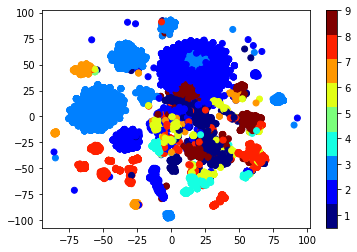

In [56]:
#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(df.drop(['Id','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

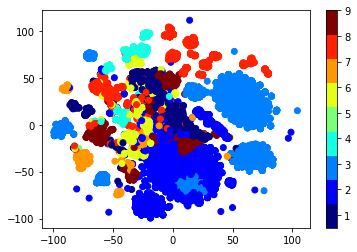

In [58]:
#this is with perplexity 30
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(df.drop(['Id','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(['Id','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train,stratify=Y_train,test_size=0.20)

In [65]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739




 Count Analysis for  Train Data


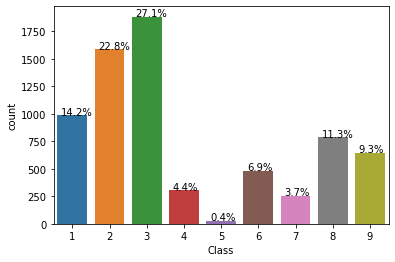

3    1883
2    1586
1     986
8     786
9     648
6     481
4     304
7     254
5      27
Name: Class, dtype: int64


 Count Analysis for  Test Data


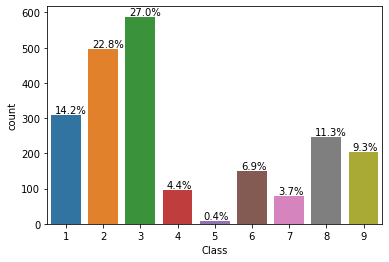

3    588
2    496
1    308
8    246
9    203
6    150
4     95
7     80
5      8
Name: Class, dtype: int64


 Count Analysis for  CV Data


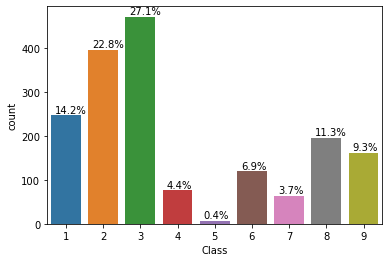

3    471
2    396
1    247
8    196
9    162
6    120
4     76
7     64
5      7
Name: Class, dtype: int64


In [75]:
def Count_analy(X,title):
    print("\n\n Count Analysis for ",title)
    sns.countplot(x=X)
    ax= plt.gca()
    for p in ax.patches:
            ax.annotate('{:.1f}%'.format(100*p.get_height()/len(X)), (p.get_x()+0.1, p.get_height()+5))
    plt.show()
    print(pd.Series(X).value_counts())

Count_analy(Y_train,'Train Data')
Count_analy(Y_test,'Test Data')
Count_analy(Y_cv,'CV Data')

In [77]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

<h1>4. Machine Learning Models</h1>

<h2>4.1. Machine Leaning Models on bytes files</h2>

<h3>4.1.1. Random Model</h3>
 Here we are not using AUROC so we do not have any base model score to comparing with (which is 0.5 in AUROC), and LogLoss lies between [0,Infinity). So we are going to create an random model, so that we would have an base model logloss score to compare with.

Log loss on Cross Validation Data using Random Model 2.4987704998308056
Log loss on Test Data using Random Model 2.5051268376522
Number of misclassified points  89.97240110395585
-------------------------------------------------- Confusion matrix --------------------------------------------------


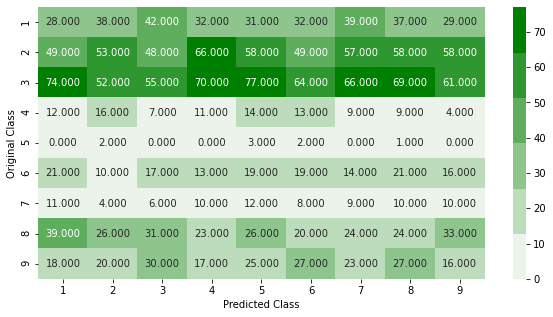

-------------------------------------------------- Precision matrix --------------------------------------------------


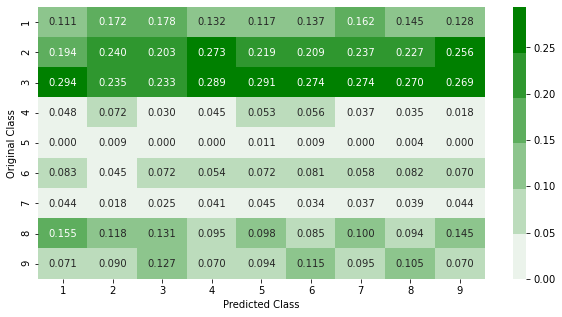

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


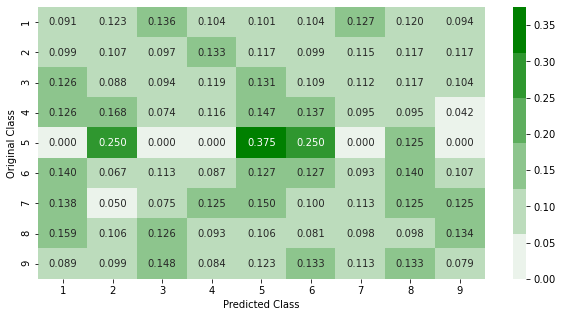

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [80]:
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(Y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y+1)

#### `So here we have got Test LogLoss as 2.5 and that for CV is 2.5, Hence we should look for an model with logloss between [0,2.5) `

<h3>4.1.2. K Nearest Neighbour Classification</h3>

In [111]:
knn_clf = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
knn_clf.fit(X_train,Y_train)
knn_clf_cali = CalibratedClassifierCV(knn_clf, method="sigmoid",n_jobs=-1)
knn_clf_cali.fit(X_train, Y_train)
knn_pred_train = knn_clf_cali.predict_proba(X_train)
knn_pred_test = knn_clf_cali.predict_proba(X_test)
knn_pred_cv = knn_clf_cali.predict_proba(X_cv)
log_loss(Y_train,knn_pred_train,eps=1e-15),log_loss(Y_test,knn_pred_test,eps=1e-15),log_loss(Y_cv,knn_pred_cv,eps=1e-15)

(0.1541983119837124, 0.2464429680796748, 0.24789064001065483)

In [127]:
gs_knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1),{'n_neighbors':[1,2,4,6,10,15,20]},n_jobs=-1)
gs_knn_clf.fit(X_train,Y_train)
gs_knn_clf_cali = CalibratedClassifierCV(gs_knn_clf.best_estimator_, method="sigmoid",n_jobs=-1)
gs_knn_clf_cali.fit(X_train, Y_train)
gs_knn_pred_train = gs_knn_clf_cali.predict_proba(X_train)
gs_knn_pred_test = gs_knn_clf_cali.predict_proba(X_test)
log_loss(Y_train,gs_knn_pred_train,eps=1e-15),log_loss(Y_test,gs_knn_pred_test,eps=1e-15)

(0.06613745062706897, 0.25782305527821375)

Looks like overfit

In [128]:
gs_knn_clf.best_estimator_

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [129]:
gs_knn_clf.cv_results_

{'mean_fit_time': array([0.02353683, 0.02454901, 0.07259583, 0.06304522, 0.0631248 ,
        0.10332961, 0.07407212]),
 'std_fit_time': array([0.00048844, 0.0018738 , 0.02572774, 0.0536527 , 0.03079885,
        0.03426766, 0.05991414]),
 'mean_score_time': array([0.79395051, 0.93756905, 0.78273463, 0.72765336, 0.80478263,
        0.66785798, 0.61903071]),
 'std_score_time': array([0.04787894, 0.17424793, 0.07396318, 0.11425729, 0.08027381,
        0.11090321, 0.05228363]),
 'param_n_neighbors': masked_array(data=[1, 2, 4, 6, 10, 15, 20],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 4},
  {'n_neighbors': 6},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20}],
 'split0_test_score': array([0.95974119, 0.94392523, 0.93961179, 0.92451474, 0.90797987,
        0.891445  , 0.87275341]),
 'split1_test_score': array([0.9503954 , 0.

In [132]:
for n in [1,2,4,6,10,15,20]: 
    knn_clf = KNeighborsClassifier(n_neighbors=n,n_jobs=-1)
    knn_clf.fit(X_train,Y_train)
    knn_clf_cali = CalibratedClassifierCV(knn_clf, method="sigmoid",n_jobs=-1)
    knn_clf_cali.fit(X_train, Y_train)
    knn_pred_train = knn_clf_cali.predict_proba(X_train)
    knn_pred_test = knn_clf_cali.predict_proba(X_test)
    knn_pred_cv = knn_clf_cali.predict_proba(X_cv)
    print('For n = ',n,' ',log_loss(Y_train,knn_pred_train,eps=1e-15),log_loss(Y_test,knn_pred_test,eps=1e-15),log_loss(Y_cv,knn_pred_cv,eps=1e-15),'\n')

For n =  1   0.06613745062706897 0.25782305527821375 0.24655987288007736 

For n =  2   0.08354576430343157 0.24096872607978825 0.22977087738417776 

For n =  4   0.13368136498985517 0.2392338137860427 0.23685143350845397 

For n =  6   0.1699153477223449 0.25395920774563413 0.26064105758620937 

For n =  10   0.21699356142026055 0.2821367824088365 0.2957626396228825 

For n =  15   0.2492762301534708 0.3079671807857823 0.32694978775709427 

For n =  20   0.2739703456907681 0.32610628777352024 0.3521586979659925 



Number of misclassified points  5.151793928242871
-------------------------------------------------- Confusion matrix --------------------------------------------------


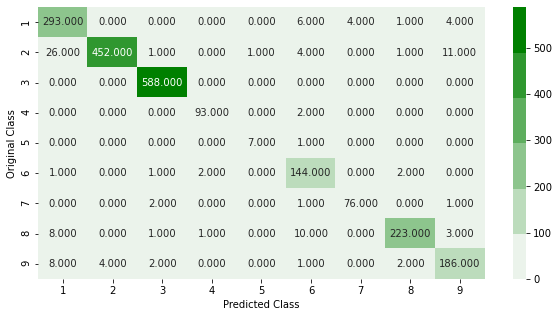

-------------------------------------------------- Precision matrix --------------------------------------------------


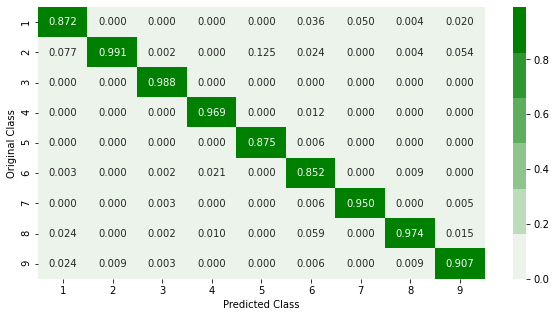

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


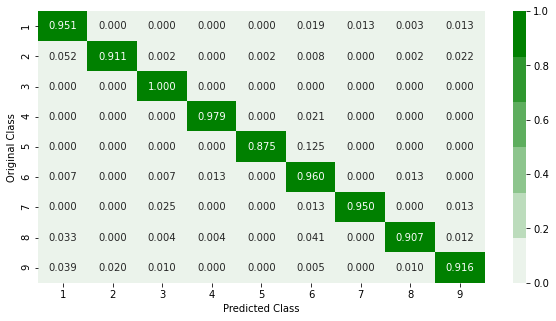

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [133]:
knn_clf = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)
knn_clf.fit(X_train,Y_train)
knn_clf_cali = CalibratedClassifierCV(knn_clf, method="sigmoid",n_jobs=-1)
knn_clf_cali.fit(X_train, Y_train)
plot_confusion_matrix(Y_test, knn_clf_cali.predict(X_test))

<h3>4.1.3. Logistic Regression</h3>

In [138]:
for n in [10 ** x for x in range(-5, 4)]: 
    logreg_clf = LogisticRegression(penalty='l2',C=n,n_jobs=-1,class_weight='balanced')
    logreg_clf.fit(X_train,Y_train)
    logreg_clf_cali = CalibratedClassifierCV(logreg_clf, method="sigmoid",n_jobs=-1)
    logreg_clf_cali.fit(X_train, Y_train)
    logreg_pred_train = logreg_clf_cali.predict_proba(X_train)
    logreg_pred_test = logreg_clf_cali.predict_proba(X_test)
    logreg_pred_cv = logreg_clf_cali.predict_proba(X_cv)
    print('For alpha = ',n,' ',log_loss(Y_train,logreg_pred_train,eps=1e-15),log_loss(Y_test,logreg_pred_test,eps=1e-15),log_loss(Y_cv,logreg_pred_cv,eps=1e-15),'\n')

For alpha =  1e-05   1.1373427644181096 1.1591045284388208 1.1322399466971569 

For alpha =  0.0001   1.1373141005826175 1.159080117188733 1.1322110367572629 

For alpha =  0.001   1.134219000561849 1.1560964653824208 1.12919523579984 

For alpha =  0.01   1.1089803996987198 1.131934992534251 1.1045626664795865 

For alpha =  0.1   1.0116639403342764 1.0403370406930328 1.0100817709105532 

For alpha =  1   0.9471985699861244 0.9754198896133224 0.9396866839684865 

For alpha =  10   0.8640498400189691 0.8989021162269509 0.8635357238926651 

For alpha =  100   0.8460677207653677 0.8673398399471809 0.8528701133673611 

For alpha =  1000   0.8565250603518386 0.8777233305566045 0.8661090498464518 



Number of misclassified points  25.666973321067154
-------------------------------------------------- Confusion matrix --------------------------------------------------


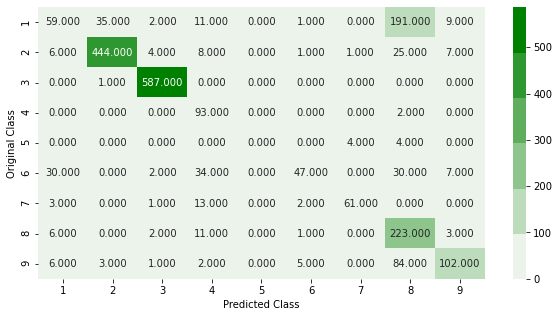

-------------------------------------------------- Precision matrix --------------------------------------------------


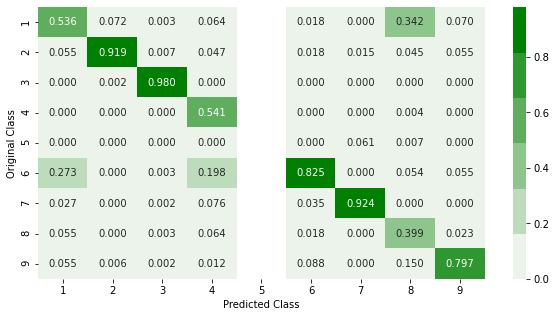

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


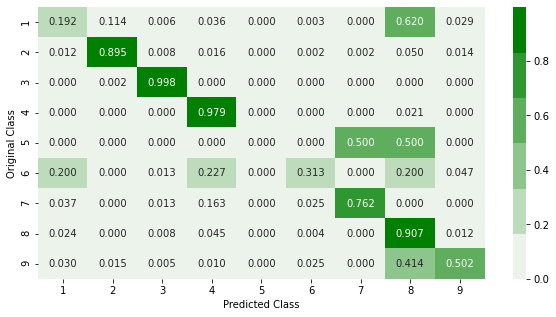

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [139]:
logreg_clf = LogisticRegression(penalty='l2',C=100,n_jobs=-1)
logreg_clf.fit(X_train,Y_train)
logreg_clf_cali = CalibratedClassifierCV(logreg_clf, method="sigmoid",n_jobs=-1)
logreg_clf_cali.fit(X_train, Y_train)
plot_confusion_matrix(Y_test, logreg_clf_cali.predict(X_test))

<h3> 4.1.4. Random Forest Classifier </h3>

In [140]:
for n in [10,50,100,500,1000,2000,3000]: 
    rdmfor_clf = RandomForestClassifier(n_estimators=n,n_jobs=-1,random_state=42,class_weight='balanced')
    rdmfor_clf.fit(X_train,Y_train)
    rdmfor_clf_cali = CalibratedClassifierCV(rdmfor_clf, method="sigmoid",n_jobs=-1)
    rdmfor_clf_cali.fit(X_train, Y_train)
    rdmfor_pred_train = rdmfor_clf_cali.predict_proba(X_train)
    rdmfor_pred_test = rdmfor_clf_cali.predict_proba(X_test)
    rdmfor_pred_cv = rdmfor_clf_cali.predict_proba(X_cv)
    print('For alpha = ',n,' ',log_loss(Y_train,rdmfor_pred_train,eps=1e-15),log_loss(Y_test,rdmfor_pred_test,eps=1e-15),log_loss(Y_cv,rdmfor_pred_cv,eps=1e-15),'\n')

For alpha =  10   0.035032435743716124 0.09702557281439665 0.08975573584559675 

For alpha =  50   0.028227796910082176 0.08632311045466248 0.08088291219568429 

For alpha =  100   0.026961165062450207 0.08521226178484732 0.08178518464511357 

For alpha =  500   0.026047248104184396 0.08425633483672726 0.08090158462282598 

For alpha =  1000   0.025833221958068992 0.08362155190510816 0.08069123271376132 

For alpha =  2000   0.025798592830101077 0.0833569850046725 0.08046225631425047 

For alpha =  3000   0.025712157755878883 0.08312271325567873 0.08055653477950518 



Number of misclassified points  1.7939282428702852
-------------------------------------------------- Confusion matrix --------------------------------------------------


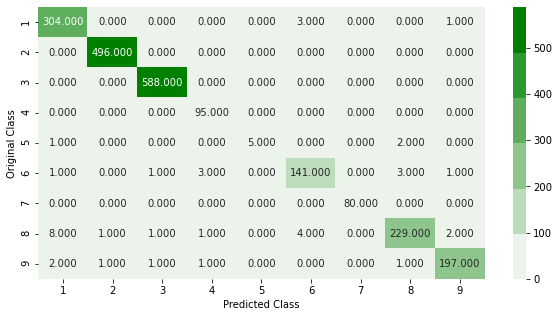

-------------------------------------------------- Precision matrix --------------------------------------------------


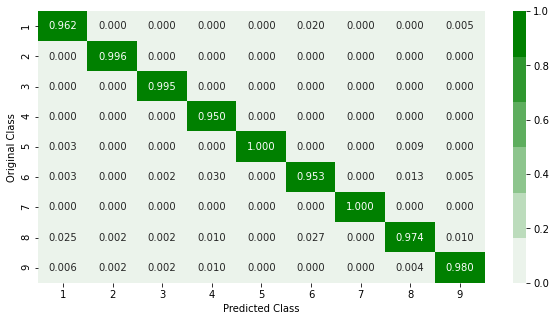

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


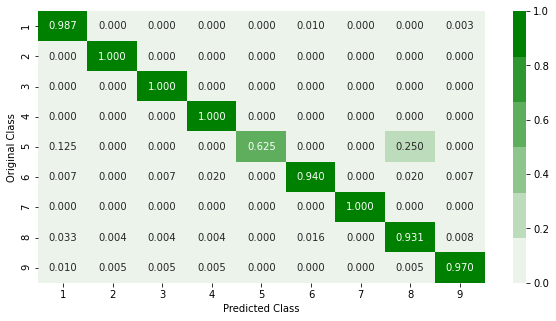

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [141]:
rdmfor_clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=42,class_weight='balanced')
rdmfor_clf.fit(X_train,Y_train)
rdmfor_clf_cali = CalibratedClassifierCV(rdmfor_clf, method="sigmoid",n_jobs=-1)
rdmfor_clf_cali.fit(X_train, Y_train)
plot_confusion_matrix(Y_test, rdmfor_clf_cali.predict(X_test))

<h3>4.1.5. XgBoost Classification</h3>

In [143]:
for n in [10,50,100,500,1000,2000,3000]: 
    xgb_clf = XGBClassifier(n_estimators=n,nthread=-1)
    xgb_clf.fit(X_train,Y_train)
    xgb_clf_cali = CalibratedClassifierCV(xgb_clf, method="sigmoid",n_jobs=-1)
    xgb_clf_cali.fit(X_train, Y_train)
    xgb_pred_train = xgb_clf_cali.predict_proba(X_train)
    xgb_pred_test = xgb_clf_cali.predict_proba(X_test)
    xgb_pred_cv = xgb_clf_cali.predict_proba(X_cv)
    print('For alpha = ',n,' ',log_loss(Y_train,xgb_pred_train,eps=1e-15),log_loss(Y_test,xgb_pred_test,eps=1e-15),log_loss(Y_cv,xgb_pred_cv,eps=1e-15),'\n')

[01:59:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For alpha =  10   0.038305054762687744 0.10210991375710898 0.08854092554355798 

[01:59:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For alpha =  50   0.023329424887793757 0.08603274128770418 0.07243128772006695 

[02:00:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from

For alpha =  3000   0.02278202652746761 0.08491964247230849 0.06921480985047816 

Number of misclassified points  1.7479300827966882
-------------------------------------------------- Confusion matrix --------------------------------------------------


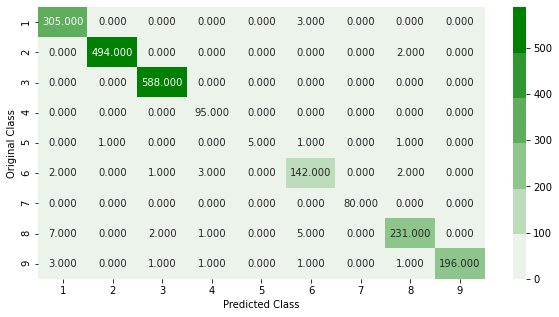

-------------------------------------------------- Precision matrix --------------------------------------------------


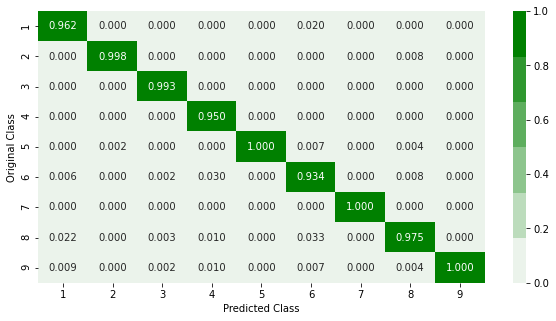

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


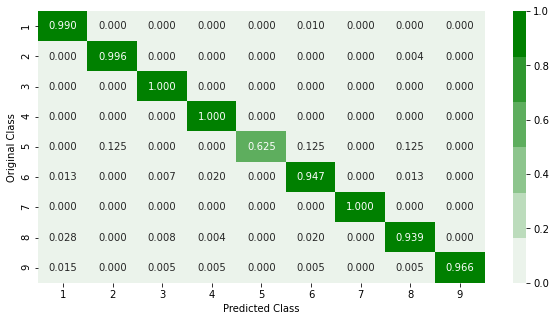

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [149]:
xgb_clf = XGBClassifier(n_estimators=1000,nthread=-1)
xgb_clf.fit(X_train,Y_train)
xgb_clf_cali = CalibratedClassifierCV(xgb_clf, method="sigmoid",n_jobs=-1)
xgb_clf_cali.fit(X_train, Y_train)
xgb_pred_train = xgb_clf_cali.predict_proba(X_train)
xgb_pred_test = xgb_clf_cali.predict_proba(X_test)
xgb_pred_cv = xgb_clf_cali.predict_proba(X_cv)
print('For alpha = ',n,' ',log_loss(Y_train,xgb_pred_train,eps=1e-15),log_loss(Y_test,xgb_pred_test,eps=1e-15),log_loss(Y_cv,xgb_pred_cv,eps=1e-15),'\n')
plot_confusion_matrix(Y_test, xgb_clf_cali.predict(X_test))

In [ ]:
xgb_clf=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
rndcv_xgb_clf=RandomizedSearchCV(xgb_clf,param_distributions=prams,verbose=10,n_jobs=-1)
rndcv_xgb_clf.fit(X_train,Y_train)

In [ ]:
print (random_cfl1.best_params_)

In [ ]:
xgb_clf = XGBClassifier(n_estimators=n,nthread=-1) # best params
xgb_clf.fit(X_train,Y_train)
xgb_clf_cali = CalibratedClassifierCV(xgb_clf, method="sigmoid",n_jobs=-1)
xgb_clf_cali.fit(X_train, Y_train)
xgb_pred_train = xgb_clf_cali.predict_proba(X_train)
xgb_pred_test = xgb_clf_cali.predict_proba(X_test)
xgb_pred_cv = xgb_clf_cali.predict_proba(X_cv)
print('For alpha = ',n,' ',log_loss(Y_train,xgb_pred_train,eps=1e-15),log_loss(Y_test,xgb_pred_test,eps=1e-15),log_loss(Y_cv,xgb_pred_cv,eps=1e-15),'\n')
plot_confusion_matrix(Y_test, xgb_clf_cali.predict(X_test))

In [152]:
with open('data/chkpt1.pkl','wb') as f:
    pickle.dump(df,f)

In [154]:
with open('data/chkpt1.pkl','rb') as f:
    trmpdf = pickle.load(f)

In [155]:
trmpdf

0         1         2         3         4         5         6  \
0      0.262806  0.005498  0.001567  0.002067  0.002048  0.001835  0.002058   
1      0.017358  0.011737  0.004033  0.003876  0.005303  0.003873  0.004747   
2      0.040827  0.013434  0.001429  0.001315  0.005464  0.005280  0.005078   
3      0.009209  0.001708  0.000404  0.000441  0.000770  0.000354  0.000310   
4      0.008629  0.001000  0.000168  0.000234  0.000342  0.000232  0.000148   
...         ...       ...       ...       ...       ...       ...       ...   
10863  0.002300  0.001657  0.000596  0.000659  0.000758  0.000656  0.000644   
10864  0.001324  0.000420  0.000138  0.000158  0.000168  0.000121  0.000114   
10865  0.002476  0.000311  0.000150  0.000174  0.000192  0.000088  0.000140   
10866  0.001588  0.000615  0.000252  0.000273  0.000313  0.000221  0.000243   
10867  0.001543  0.000525  0.000214  0.000233  0.000303  0.000226  0.000222   

              7         8         9  ...       250       251       252  \
0      0.002946  0.002638  0.003531  ...  0.013107  0.013634  0.031724   
1      0.006984  0.008267  0.000394  ...  0.001147  0.001329  0.087867   
2      0.002155  0.008104  0.002707  ...  0.011777  0.012604  0.028423   
3      0.000481  0.000959  0.000521  ...  0.001886  0.002272  0.013032   
4      0.000229  0.000376  0.000246  ...  0.000853  0.001052  0.007511   
...         ...       ...       ...  ...       ...       ...       ...   
10863  0.001036  0.001022  0.001257  ...  0.004711  0.004790  0.012802   
10864  0.000204  0.000229  0.000258  ...  0.000825  0.000946  0.002393   
10865  0.000135  0.000232  0.000172  ...  0.001008  0.000718  0.002864   
10866  0.000375  0.000360  0.000454  ...  0.001535  0.001550  0.006246   
10867  0.000343  0.000355  0.000376  ...  0.001339  0.001488  0.005510   

            253       254       255       256                    Id  Class  \
0      0.014549  0.014348  0.007843  0.000129  01azqd4InC7m9JpocGv5      9   
1      0.002432  0.088411  0.074851  0.000606  01IsoiSMh5gxyDYTl4CB      2   
2      0.013080  0.013937  0.067001  0.000033  01jsnpXSAlgw6aPeDxrU      9   
3      0.002211  0.003957  0.010904  0.000984  01kcPWA9K2BOxQeS5Rju      1   
4      0.001038  0.001258  0.002998  0.000636  01SuzwMJEIXsK7A8dQbl      8   
...         ...       ...       ...       ...                   ...    ...   
10863  0.005230  0.005757  0.001606  0.024554  loIP1tiwELF9YNZQjSUO      4   
10864  0.000915  0.001019  0.000458  0.001014  LOP6HaJKXpkic5dyuVnT      4   
10865  0.000700  0.001175  0.000315  0.000804  LOqA6FX02GWguYrI1Zbe      4   
10866  0.001695  0.001716  0.000600  0.006039  LoWgaidpb2IUM5ACcSGO      4   
10867  0.001582  0.001820  0.000534  0.005568  lS0IVqXeJrN6Dzi9Pap1      4   

          fsize  
0      0.092219  
1      0.121236  
2      0.084499  
3      0.010759  
4      0.006233  
...         ...  
10863  0.039776  
10864  0.002772  
10865  0.002772  
10866  0.010226  
10867  0.009162  

[10868 rows x 260 columns]

<h2> 4.2 Modeling with .asm files </h2>

<pre>
There are 10868 files of asm 
All the files make up about 150 GB
The asm files contains :
1. Address
2. Segments
3. Opcodes
4. Registers
5. function calls
6. APIs
With the help of parallel processing we extracted all the features.In parallel we can use all the cores that are present in our computer.


Here we extracted 52 features from all the asm files which are important.

We read the top solutions and handpicked the features from those papers/videos/blogs. <br> Refer:https://www.kaggle.com/c/malware-classification/discussion
</pre>

<h3> 4.2.1 Feature extraction from asm files </h3>

<p>
<li> To extract the unigram features from the .asm files we need to process ~150GB of data </li>
<li style="font-size:18px"><b>Note: Below two cells will take lot of time (over 48 hours to complete)</b></li>
<li> We will provide you the output file of these two cells, which you can directly use it </li>
</p>